# Time series forecasting project

In [2]:
# Handle imports up-front
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from pmdarima import auto_arima

## 1. Data loading

### 1.1. Load

In [3]:
dataset='flights'

In [4]:
if dataset == 'flights':
    raw_data_df=sns.load_dataset("flights")

elif dataset == 'sales':
    raw_data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')

### 1.2. Inspect 

In [5]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


### 1.3. Encode date feature

Pandas has many great tools to work with timeseries data - see the user guide article: '*[Time series / date functionality](https://pandas.pydata.org/docs/user_guide/timeseries.html)*'. First thing to do is convert our string date feature(s) to a Datetime object.

In [6]:
# Make a copy of the raw data to work with
timeseries_df=raw_data_df.copy()

# Extract the string month to a datetime object feature
timeseries_df['month']=pd.to_datetime(raw_data_df.month, format='%b').dt.month

# Use the month and year to create at 'date' datetime feature
timeseries_df['date']=pd.to_datetime(timeseries_df[['year', 'month']].assign(day=1))

# Set the datetime feature as the index
timeseries_df=timeseries_df.set_index('date')

# Keep only the passenger column
timeseries_df.drop(['year', 'month'], axis=1, inplace=True)

# Re-name 'passengers' to 'dependent_var' so we can easily swap datasets without making
# changes to the notebook
timeseries_df.rename(columns={'passengers': 'dependent_var'}, inplace=True)

# Check the result
timeseries_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   dependent_var  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


## 2. EDA

### 2.1. Baseline model performance

Let's set a quick performance baseline using a quick/easy linear regression model.

In [7]:
# Your code here! Hint use a numeric range equal to the length of the dataset for x.
linear_model=LinearRegression()

# Generate a uniform x variabel representing the time steps
x=np.array(range(len(timeseries_df))).reshape(-1, 1)

# Fit the model
fit_result=linear_model.fit(x, timeseries_df['dependent_var'])

# Make predictions over the input domain
predictions=linear_model.predict(x)

# Add the linear model predictions back to the dataframe
timeseries_df['Linear model']=predictions

# Calcualte the root mean squared error
rmse=sqrt(mean_squared_error(timeseries_df['dependent_var'], predictions))

# Save the result for later
rmse_results={'Linear model': rmse}

# Display the result for the user
print(f'Root mean square error: {rmse:.1f}')


Root mean square error: 45.7


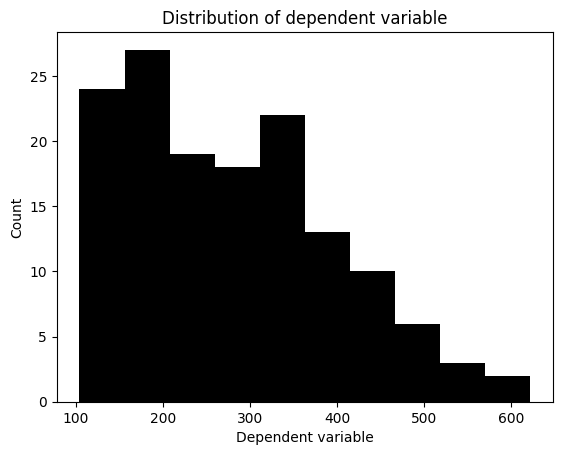

In [8]:
plt.title('Distribution of dependent variable')
plt.hist(timeseries_df['dependent_var'], color='black')
plt.xlabel('Dependent variable')
plt.ylabel('Count')
plt.show()

In [9]:
missing_data = timeseries_df.isnull().sum()

print(missing_data)

dependent_var    0
Linear model     0
dtype: int64


### 2.2. Missing, and/or extreme values

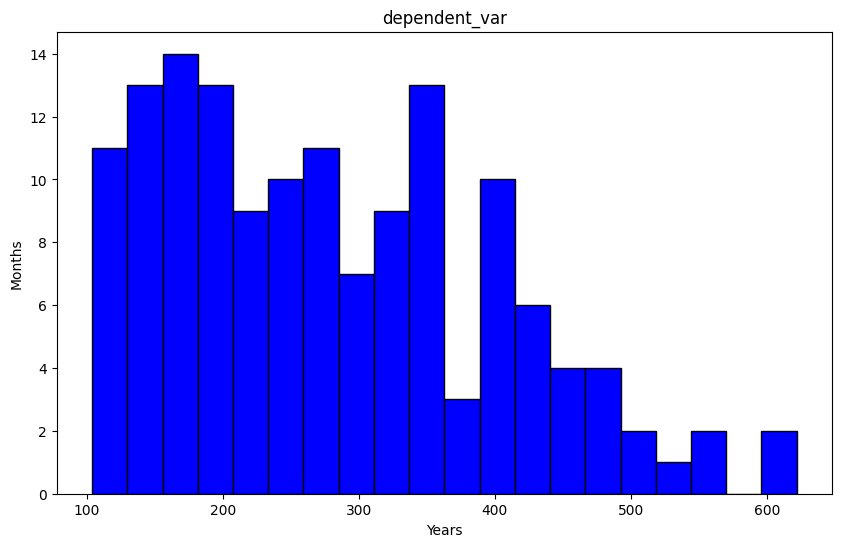

In [10]:
# Plot data as a historgram as you normaly would for any numerical data
plt.figure(figsize=(10, 6))
plt.hist(timeseries_df['dependent_var'], bins=20, color='blue', edgecolor='black')
plt.xlabel('Years')
plt.ylabel('Months')
plt.title('dependent_var')
plt.show()

In [11]:
from fancyimpute import KNN
imputer = KNN(k=3)
imputed_data = imputer.fit_transform(timeseries_df)

Imputing row 1/144 with 0 missing, elapsed time: 0.003
Imputing row 101/144 with 0 missing, elapsed time: 0.003


/home/vscode/.local/lib/python3.10/site-packages/fancyimpute/solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


### 2.3. Timeseries analysis

Let's now take a look at the data as a timeseries. There are a couple of things to look out for here.

1. Is the time axis regular - i.e. are the rows evenly spaced in time.
2. Is the data stationary - i.e. is there a consistent trend over time. The answer to this question will effect how we model the data.
3. Are there regular or cyclical trends - e.g. sales are high on Mondays and low on weekends.

### 2.3.1. Plot the time-series

Let's include predictions from the baseline model too and see what we are working with.

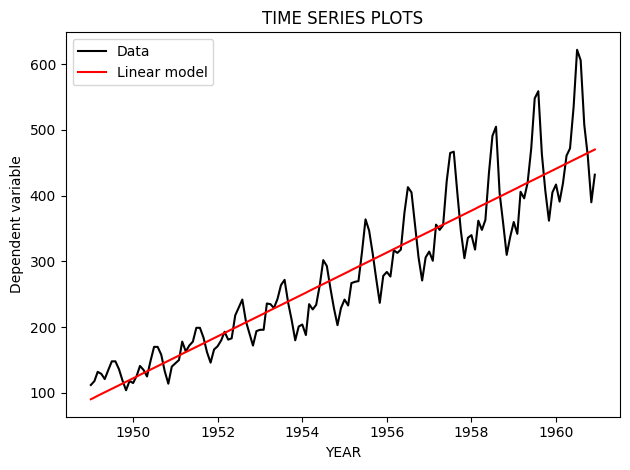

In [12]:
# Plot the data over time and include the linear regression from above
plt.title('TIME SERIES PLOTS')
plt.plot(timeseries_df['dependent_var'], label='Data', color='black')
plt.plot(timeseries_df['Linear model'], label='Linear model', color='red')
plt.xlabel('YEAR')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### 2.3.2. Missing timepoints

Next, do a quick check to see if the datetime index we just created is evenly spaced - i.e. the time delta between the rows is always the same.

In [13]:
# Your code here. Hint: take a look and Panda's .resample()
time_deltas = timeseries_df.index.to_series().diff().dropna()

is_evenly_spaced = time_deltas.nunique() == 1

print(f"Is the datetime index evenly spaced? {is_evenly_spaced}")



Is the datetime index evenly spaced? False


### 2.3.3. Stationarity

Dicky-Fuller p-value: 0.992


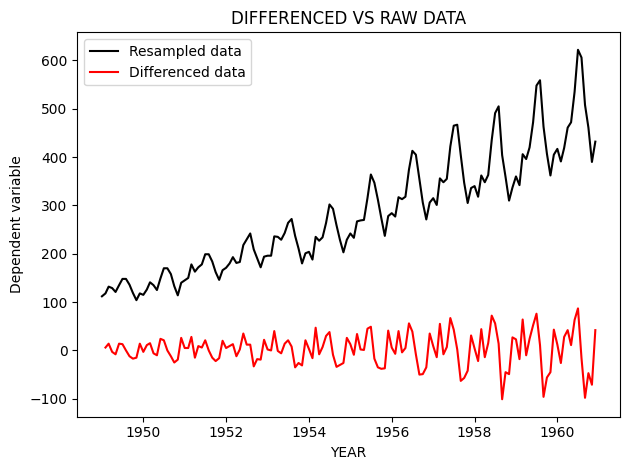

In [14]:
# Note: you want to be aware of this property of your data, but you may or may not have to do anything with this information right away!
from statsmodels.tsa.stattools import adfuller

dftest=adfuller(timeseries_df['dependent_var'], autolag = "AIC")
print(f'Dicky-Fuller p-value: {dftest[1]:.3f}')

stationary_timeseries_df=timeseries_df['dependent_var'].diff().dropna()

plt.title('DIFFERENCED VS RAW DATA')
plt.plot(timeseries_df.index, timeseries_df['dependent_var'], label='Resampled data', color='black')
plt.plot(stationary_timeseries_df.index, stationary_timeseries_df, label='Differenced data', color='red')
plt.xlabel('YEAR')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### 2.3.4. Seasonality

In [15]:
# Note: you want to be aware of this property of your data, but you may or may not have to do anything with this information right away!
from pmdarima import auto_arima

timeseries_model = auto_arima(
    timeseries_df['dependent_var'],  
    seasonal=True,                   
    stationary=False,                 
    trace=True,                       
    m=12                              
)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=0.96 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.13 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=0.49 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=0.18 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=0.58 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.12 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.21 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=0.45 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=0.41 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=1.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.06 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.05 sec
 ARIMA(3,1,1)(0,1,0

## 3. Model training

In [18]:
# Hint use the 'auto_arima()' function from pmdarima as describe in the reading on 4Geeks.
timeseries_model=auto_arima(timeseries_df['dependent_var'], seasonal=True, stationary=False, trace=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=0.85 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.12 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=0.54 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=0.17 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=0.53 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.09 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.22 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=0.45 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=0.40 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=0.85 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.06 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.06 sec
 ARIMA(3,1,1)(0,1,0

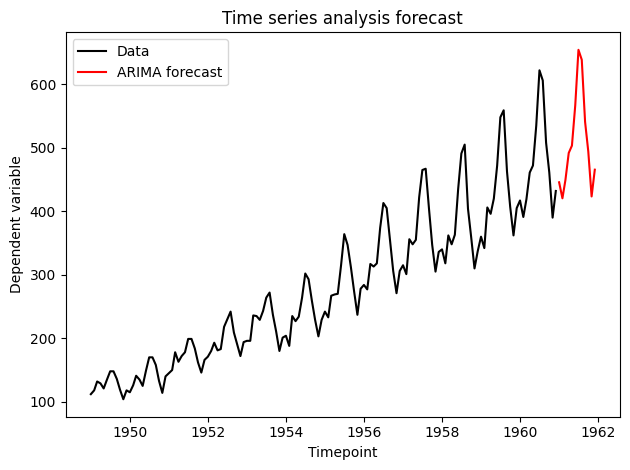

In [20]:
forecast=timeseries_model.predict(12)

plt.title('Time series analysis forecast')
plt.plot(timeseries_df['dependent_var'], label='Data', color='black')
plt.plot(forecast, label='ARIMA forecast', color='red')
plt.xlabel('Timepoint')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

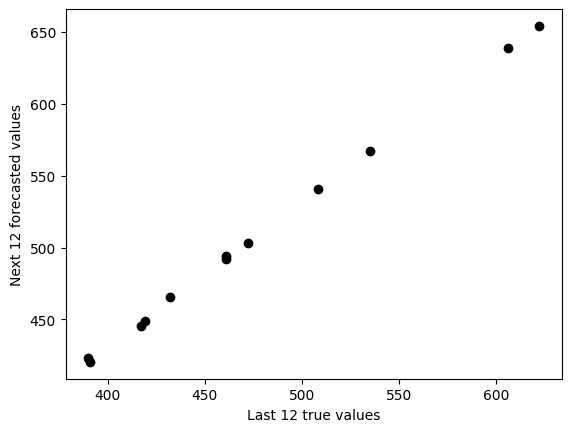

In [21]:
true_data=timeseries_df['dependent_var'][-12:]

# Plot them against the predictions
plt.scatter(true_data, forecast, color='black')
plt.xlabel('Last 12 true values')
plt.ylabel('Next 12 forecasted values')
plt.show()

In [23]:
# Set a forecast horizon, i.e. how far into the future, we want to predict
forecast_horizon=10

# Set a model order, i.e. how many past datapoints should be used as input for prediction
model_order=40

In [24]:
testdf_size=forecast_horizon

traindf_size=len(timeseries_df) - testdf_size

training_data=timeseries_df[:traindf_size]
testing_data=timeseries_df[traindf_size:]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=236.858, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=218.288, Time=0.14 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=223.009, Time=0.12 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=267.264, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=217.180, Time=0.03 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=218.106, Time=0.08 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=218.439, Time=0.06 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=218.547, Time=0.06 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=224.610, Time=0.04 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=220.434, Time=0.18 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=219.591, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,1,0)[12] intercept
Total fit time: 1.767 seconds
Performing stepwise search to

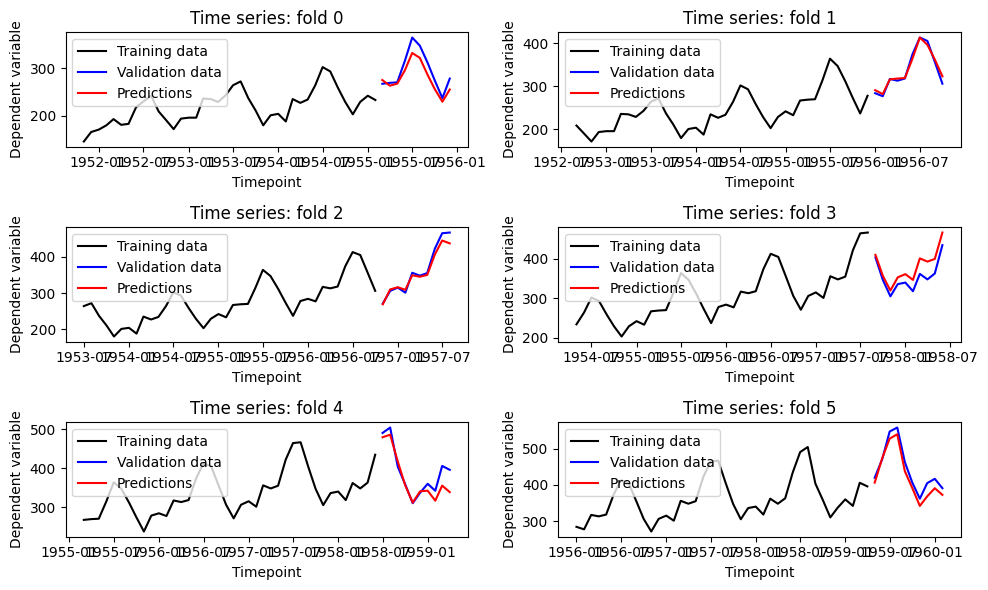

In [25]:
# Number of 'cross-validation' folds to run
folds=6

# Holders to collect data for later
validation_rmse_values=[]
predicted_values=[]
validation_values=[]

# Set-up a multiplot for the results
fig, axs=plt.subplots(3, 2, figsize=(10,6))
axs=axs.flatten()

# Instantiate a time series splitter
timeseries_splits=TimeSeriesSplit(n_splits=folds, max_train_size=model_order, test_size=forecast_horizon)

# Loop on the splits with a counter
for i, timeseries_split in enumerate(timeseries_splits.split(training_data)):

    # Recover the split indicies
    training_indicies=timeseries_split[0]
    validation_indicies=timeseries_split[1]

    # Get the data for this split from the training data
    fold_training_data=training_data.iloc[training_indicies, :]
    fold_validation_data=training_data.iloc[validation_indicies, :]

    # Fit the model and predict out to the forecast horizon
    timeseries_model=auto_arima(fold_training_data['dependent_var'], stationary=False, trace=True, seasonal=True, m=12, suppress_warnings=True)
    forecast=timeseries_model.predict(forecast_horizon)

    # Collect intermediate results
    predicted_values.extend(forecast)
    validation_values.extend(fold_validation_data['dependent_var'])

    rmse=sqrt(mean_squared_error(fold_validation_data['dependent_var'], forecast))
    validation_rmse_values.append(rmse)

    # Draw the timeseries plot for this fold
    axs[i].set_title(f'Time series: fold {i}')
    axs[i].plot(fold_training_data['dependent_var'], label='Training data', color='black')
    axs[i].plot(fold_validation_data['dependent_var'], label='Validation data', color='blue')
    axs[i].plot(forecast, label='Predictions', color='red')
    axs[i].set_xlabel('Timepoint')
    axs[i].set_ylabel('Dependent variable')
    axs[i].legend(loc='best')

plt.tight_layout()
plt.show()

## 4. Model evaluation

This result *looks* convincing, at least if you don't look too close - but how well are we actualy doing? We need to implement test-train splitting and/or cross-validation to estimate the actual performance on unseen data!

Breaking up time-series data is a little bit harder than other types of tabular data - we can't just randomly select data points for the training and/or validation sets becuase the order matters!

Luckily, Scikit-learn can help us out here - take a look at [TimeSeriesSplit](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [26]:
# I'll leave it up to you to try and figure out a good way to evalueate this model!
timeseries_model=auto_arima(training_data['dependent_var'], stationary=False, seasonal=True, trace=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=919.841, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=914.982, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=915.832, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=914.468, Time=0.06 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=915.311, Time=0.16 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=916.133, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=915.810, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=915.082, Time=0.05 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=917.806, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=916.211, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 2.484 seconds


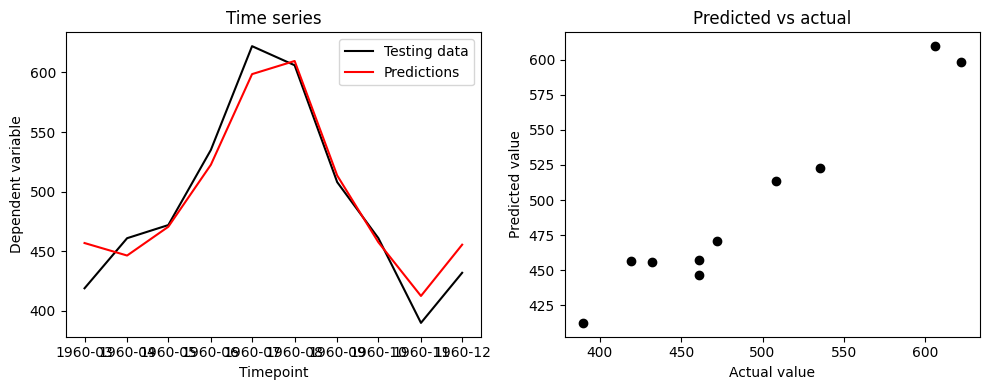

Root mean square error:
  Linear model: 45.7
  ARIMA test data: 18.6


In [28]:
# Make predictions
forecast=timeseries_model.predict(forecast_horizon)

# Plot the result
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(10,4))

ax1.set_title('Time series')
ax1.plot(testing_data['dependent_var'], label='Testing data', color='black')
ax1.plot(forecast, label='Predictions', color='red')
ax1.set_xlabel('Timepoint')
ax1.set_ylabel('Dependent variable')
ax1.legend(loc='best')

ax2.set_title('Predicted vs actual')
ax2.scatter(testing_data['dependent_var'], forecast, color='black')
ax2.set_xlabel('Actual value')
ax2.set_ylabel('Predicted value')

plt.tight_layout()
plt.show()

rmse=sqrt(mean_squared_error(testing_data['dependent_var'], forecast))
rmse_results['ARIMA test data']=rmse

print(f'Root mean square error:')

for experiment, rmse in rmse_results.items():
    print(f'  {experiment}: {rmse:.1f}')